# Creating images and plots from TIGRESS simulation vtk output

# packages to be used
 * matplotlib http://matplotlib.org/
 * numpy http://www.numpy.org/
 * pandas http://pandas.pydata.org/
 * astropy http://www.astropy.org/

### First need to import standard python packages: 

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cPickle as pickle
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm

In [68]:
#Set up your output directory here
import os
outpath='/tigress/eostrike/figs'

### To read and extract information from TIGRESS data we use modules from the pyathena package

In [69]:
import pyathena as pa
pa.__file__

'../pyathena/__init__.pyc'

## Unit system

The unit system for the TIGRESS simulations is
* [length] = pc
* [velocity] = km/s
* [density] = 1.4271*m_H/cm^3

In [70]:
#We use set_units from pyathena for units conversions
# This uses units and constants from astropy
from pyathena import set_units
set_units

<function pyathena.set_units.set_units>

In [71]:
unit=pa.set_units(muH=1.4271)
print unit['density'].cgs/1.4271/c.m_p.cgs
print unit['velocity']
print unit['length']
print unit['mass']
print unit['time']
print unit['magnetic_field']

1.0 1 / cm3
1.0 km / s
1.0 pc
0.0352682242985 solMass
0.977792221673 Myr
0.547685223955 uG


In [72]:
# other units can be easily obtained
print unit.keys()

['number_density', 'temperature', 'density', 'magnetic_field', 'pressure', 'length', 'mass', 'time', 'velocity', 'muH', 'gravitational_potential']


In [73]:
#We'll use these later
codemass=unit['mass']
codetime=unit['time']
codelength=unit['length']
codevel=unit['velocity']
print codemass,codetime,codelength,codevel

0.0352682242985 solMass 0.977792221673 Myr 1.0 pc 1.0 km / s


## Read full data cube of MHD variables 

The original data from TIGRESS simulations is written as "vtk" files. Each vtk file has data for all physical field variables (density, velocity, etc) in each cell for a part of the simulation "domain." In Athena, each sub-domain is called a "grid".  For MPI simulations, at each timestep when there is a vtk dump, Athena writes a separate vtk file from each proccessor. All the vtk files from a given processor (i.e. all time snapshots for data from a given "grid") are written to a directory for just that processor: /id0, /id1, /id2, etc.   

Here we will use the pyathena reader to open the separate vtk files from a given time, get data from each grid, and merge into a big data array for the full domain.

## The vtk file directory must be set up 

#### You may be using either simulations that have already been run (1), or new simulations (2)

### (1) Data Location for TIGRESS solar nbhd. simulations that have already been run:

* "4pc" model output can be found in directories "/tigress/changgoo/MHD_4pc/", "/tigress/changgoo/MHD_4pc_T2/", and "/tigress/changgoo/MHD_4pc_new/"

* "2pc" model (based on restart of 4pc model) output can be found in "/tigress/changgoo/MHD_2pc_new/" and "/tigress/changgoo/MHD_2pc_S/"

* There are also "8pc" and "16pc" lower-resolution data in "/tigress/changgoo/"

####  For description of the various Solar neighborhood simulations (box size, feedback type, restart time, etc.) see:
https://github.com/PrincetonUniversity/Athena-TIGRESS/wiki/Solar-Neighborhood

### (2) Data Location for new simulations:

* In general, the output files and directories for new simulations will be the same as for previous simulations, with full vtk outputs in /id0, /id1 etc, history files in /id0, star particle vtk files in /id0


### Simulations at different resolution
* In general, you will want to run analysis on the highest resolution available.  For example, you might like to analyze and make images from the "MHD_2pc_S" simulation. 
 
* However, high resolution means the data set is huge, and will be very slow to read (and manipulate).

* If it's available, it's best to play with a small data set first in order to get your plots and images set up, and 
 then move on to a larger (higher resolution) data set when you are confident with your code.  
* Even if the model you're interested in does not have a low-resolution run, you can use a different low-res model 
 as "dummy" data while you are setting up. 

In [121]:
# Here is where we read in the domain information.  The reader also parses the file name directory path to set up paths for 
#   other files
# This is for high-res:
#ds=pa.AthenaDataSet('/tigress/changgoo/MHD_2pc_S/id0/MHD_2pc_S.0400.vtk')
# This is for medium res:
#ds=pa.AthenaDataSet('/tigress/changgoo/MHD_8pc_new/id0/MHD_8pc_new.0500.vtk')
# This is for low-res:
ds=pa.AthenaDataSet('/tigress/changgoo/MHD_32pc/id0/MHD_32pc.0400.vtk')

In [122]:
#This is the directory for all files, star particle file name, number of grids 
print ds.dir, ds.starfile, ds.ngrids

/tigress/changgoo/MHD_32pc/ /tigress/changgoo/MHD_32pc/id0/MHD_32pc.0400.starpar.vtk 16


In [123]:
# names of original Athena data fields we stored from the simulation in the vtk file
ds.field_list

['density',
 'magnetic_field',
 'specific_scalar1',
 'specific_scalar0',
 'specific_scalar2',
 'pressure',
 'velocity',
 'gravitational_potential']

In [124]:
# The vtk reader includes predefined "derived" data fields that can be calculated from the original Athena data.
ds.derived_field_list

['velocity1',
 'velocity2',
 'velocity3',
 'velocity_magnitude',
 'kinetic_energy1',
 'kinetic_energy2',
 'kinetic_energy3',
 'momentum1',
 'momentum2',
 'momentum3',
 'reynold_stress',
 'reynold_stress1',
 'reynold_stress2',
 'reynold_stress3',
 'sound_speed',
 'temperature',
 'T1',
 'potential_energy',
 'gravity_stress',
 'gravity_stress1',
 'gravity_stress2',
 'gravity_stress3',
 'number_density',
 'scalar0',
 'scalar1',
 'scalar2',
 'magnetic_field1',
 'magnetic_field2',
 'magnetic_field3',
 'magnetic_energy1',
 'magnetic_energy2',
 'magnetic_energy3',
 'magnetic_pressure',
 'plasma_beta',
 'alfven_velocity1',
 'alfven_velocity2',
 'alfven_velocity3',
 'magnetic_stress',
 'magnetic_stress1',
 'magnetic_stress2',
 'magnetic_stress3']

In [125]:
# This is a variety of parameter information for the whole domain
# Note that Lx[0]=Lx, Lx[1]=Ly, Lx[2]=Lz and similarly for Nx, dx, left_edge, right_edge
ds.domain

{'Lx': array([ 1024.,  1024.,  4096.], dtype=float32),
 'Nx': array([ 32,  32, 128]),
 'center': array([ 0.,  0.,  0.], dtype=float32),
 'dx': array([ 32.,  32.,  32.], dtype=float32),
 'field_map': {'density': {'dsize': 32768,
   'dtype': 'f',
   'ndata': 8192,
   'nvar': 1,
   'offset': 252,
   'read_table': True},
  'gravitational_potential': {'dsize': 32768,
   'dtype': 'f',
   'ndata': 8192,
   'nvar': 1,
   'offset': 262540,
   'read_table': True},
  'magnetic_field': {'dsize': 98304,
   'dtype': 'f',
   'ndata': 24576,
   'nvar': 3,
   'offset': 164205,
   'read_table': False},
  'pressure': {'dsize': 32768,
   'dtype': 'f',
   'ndata': 8192,
   'nvar': 1,
   'offset': 131392,
   'read_table': True},
  'specific_scalar0': {'dsize': 32768,
   'dtype': 'f',
   'ndata': 8192,
   'nvar': 1,
   'offset': 295368,
   'read_table': True},
  'specific_scalar1': {'dsize': 32768,
   'dtype': 'f',
   'ndata': 8192,
   'nvar': 1,
   'offset': 328191,
   'read_table': True},
  'specific_scala

In [126]:
# parameter information for grid #4
ds.grids[4]

{'Nx': array([16, 16, 32]),
 'data': {},
 'data_offset': 252,
 'dx': array([ 32.,  32.,  32.]),
 'filename': '/tigress/changgoo/MHD_32pc/id4/MHD_32pc-id4.0400.vtk',
 'is': array([ 0,  0, 32]),
 'left_edge': array([ -512.,  -512., -1024.]),
 'ncells': 8192,
 'prim_var_type': True,
 'read_field': 'density',
 'read_type': 'scalar',
 'right_edge': array([ 0.,  0.,  0.]),
 'time': 400.0025,
 'vtk_version': '2.0'}

In [127]:
ds.grids[4]['Nx']

array([16, 16, 32])

In [128]:
# Previously, we read metadata (model and numerical parameters) from the vtk file, but we have not yet read in the data itself 
# We will read the data fields for the full domain

# Note that arrays in Athena have C-like indexing: k (z-index) comes first and i (x-index) comes last
# This is the OPPOSITE of the order for domain information such as Lx[0]=Lx, Lx[1]=Ly, Lx[2]=Lz, so
#       be careful about indexing!

# We can read the original data fields (primitive variables in Athena) using read_all_data

# Read in the density (a scalar):
d=ds.read_all_data('density')
print d.shape

# Read in the velocity (a vector field with 3 components):
v=ds.read_all_data('velocity')
print v.shape
#We can now assign components of the vector to individual arrays:
vx=v[:,:,:,0]
vy=v[:,:,:,1]
vz=v[:,:,:,2]
print vx.shape


(128, 32, 32)
(128, 32, 32, 3)
(128, 32, 32)


In [129]:
#Physical coordinates of the center of the domain
ds.domain['center']

array([ 0.,  0.,  0.], dtype=float32)

In [130]:
#Indices of the center of the domain (i,j,k)
icen=ds.domain['Nx']/2
print icen

[16 16 64]


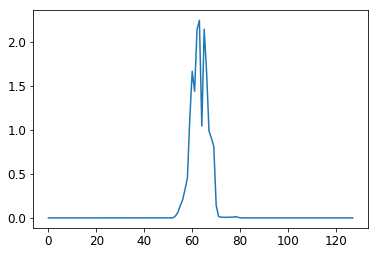

In [131]:
#This is the density along a single line perpendicular to the midplane, along z, through the center of the domain
plt.plot(d[:,icen[1],icen[0]])

([<matplotlib.lines.Line2D at 0x2b6c09c19850>],
 [<matplotlib.lines.Line2D at 0x2b6c09c28150>])

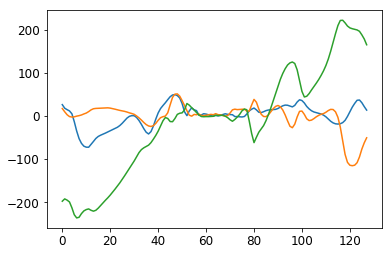

In [132]:
#These are the velocities along a single line perpendicular to the midplane, along z, through the center of the domain
plt.plot(vx[:,icen[1],icen[0]]),plt.plot(vy[:,icen[1],icen[0]]),plt.plot(vz[:,icen[1],icen[0]])

In [133]:
# We can also can read in the derived fields
v1=ds.read_all_data('velocity1')
v2=ds.read_all_data('velocity2')
v3=ds.read_all_data('velocity3')

print v1.shape

# You can check that the arrays vx (defined above) and v1 (set up by the pyathena vtk reader) are identical
print (vx == v1).all()

(128, 32, 32)
True


In [134]:
#This is domain information
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']
Nx=ds.domain['Nx']

# set up cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]

#This sets up for image plots based on the domain physical size
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
print xyextent,xzextent,yzextent

[-512.0, 512.0, -512.0, 512.0] [-512.0, 512.0, -2048.0, 2048.0] [-512.0, 512.0, -2048.0, 2048.0]


In [135]:
# calculate background velocity vy_0=-q*Omega*x
# Note that this value is particular to a given simulation!
vy0=-28.e-3*x

# substract it to get a perturbed velocity in the y-dir.
dv2=v2-np.tile(vy0.reshape(1,1,Nx[0]),(Nx[2],Nx[1],1))


In [136]:
phi=ds.read_all_data('gravitational_potential')

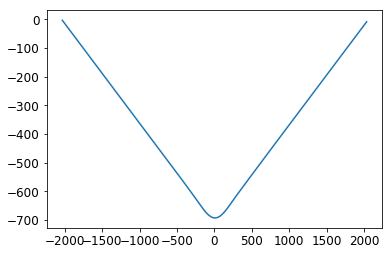

In [137]:
#You can use the coordinates, rather than indices, in plotting
plt.plot(z,phi[:,icen[1],icen[0]])

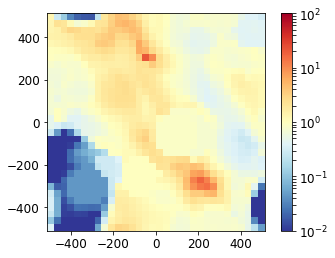

In [138]:
#This shows a slice of density through the midplane at z=0
denslice=d[icen[2],:,:]
im=plt.imshow(denslice,norm=LogNorm(),origin='lower')
im.set_extent(xyextent)
im.set_clim(1.e-2,1.e2)
im.set_cmap('RdYlBu_r')
plt.colorbar(im)

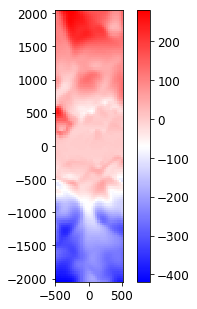

In [139]:
#This shows a slice of vertical velocity at y=Nx[1]/2
fig=plt.figure(figsize=(5,5))
im=plt.imshow(vz[:,Nx[1]/2,:],origin='lower',cmap='bwr')
im.set_extent(xzextent)
plt.colorbar(im)

10.8915


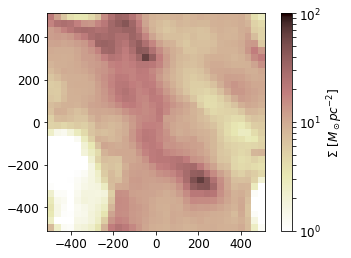

In [140]:
#You can integrate along the z-axis to create surface density
# Here we also convert from code units to Msun/pc^2
surf=d.sum(axis=0)*dx[2]*codemass.value/codelength.value**2
print np.mean(surf)
im=plt.imshow(surf,origin='lower',cmap='pink_r',norm=LogNorm())
im.set_extent(xyextent)
im.set_clim(1.e0,1.e2)
plt.colorbar(im,label='$\Sigma$ [$M_\odot pc^{-2}$]')

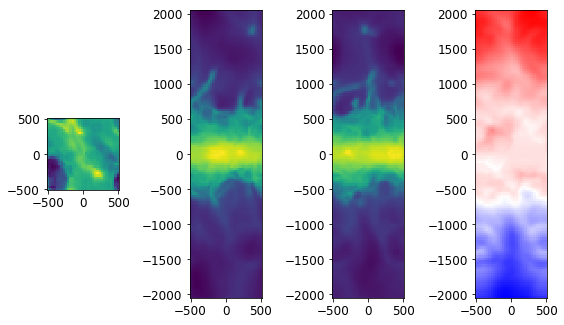

In [141]:
# We are often interested in averages, which can be created from the data
# For example:
dproj=[]
for i in range(3):
    dproj.append(d.mean(axis=i))

#We can set up the coordinate ranges for the plots:
ext=[]    
ext.append(xyextent)
ext.append(xzextent)
ext.append(yzextent)

fig=plt.figure(figsize=(8,8))    
for i in range(3):
    plt.subplot(1,4,i+1)    
    plt.imshow(dproj[i],origin='lower',norm=LogNorm(),extent=ext[i]) 
    
plt.subplot(1,4,4)    
plt.imshow(vz.mean(axis=2),origin='lower',cmap='bwr',extent=xzextent)
plt.tight_layout()

In [142]:
#You can also choose a special location and plot slices 
# For example, let's find the index for the location where the density is maximum
imax=np.argmax(d)
#unravel the index to 3d-form and swap the order to (x,y,z)
imax=np.unravel_index(imax,d.shape)[::-1]
print imax
#evaluate the coordinates at this location
max_pos=[x[imax[0]],y[imax[1]],z[imax[2]]]
print max_pos

(14, 25, 64)
[-48.0, 304.0, 16.0]


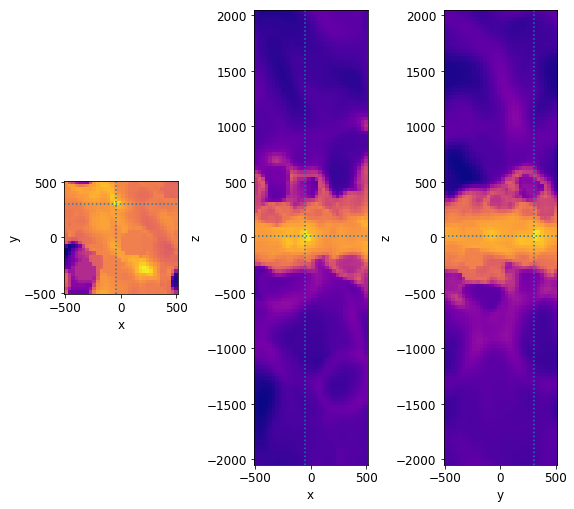

In [143]:
# Let's plot slices through the maximum

# This is another way to set up for three sub-plots which are slices through the data
x_coord=['x','x','y']
i_coord=[0,0,1]
y_coord=['y','z','z']
j_coord=[1,2,2]


fig=plt.figure(figsize=(8,8))

#Note that z-axis is first and x-axis is last for the array
dslice=[]
dslice.append(d[imax[2],:,:])
dslice.append(d[:,imax[1],:])
dslice.append(d[:,:,imax[0]])

    
for i in range(3):
    plt.subplot(1,3,i+1)
    im=plt.imshow(dslice[i],origin='lower',norm=LogNorm())
    im.set_extent([xmin[i_coord[i]],xmax[i_coord[i]],xmin[j_coord[i]],xmax[j_coord[i]]])
    im.set_cmap(plt.cm.plasma)
    plt.axvline(max_pos[i_coord[i]],ls=':')
    plt.axhline(max_pos[j_coord[i]],ls=':')
    plt.xlabel(x_coord[i])
    plt.ylabel(y_coord[i])
    
plt.tight_layout()

(10, 10, 10)


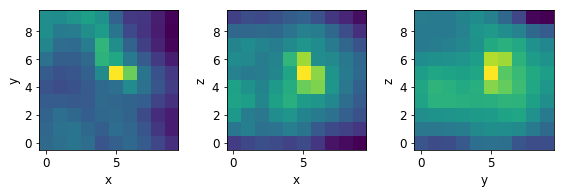

In [144]:
#You might want to zoom in on the data
# For example, let's look near the maxium in density:
zsz=10

zoom=d[imax[2]-zsz/2:imax[2]+zsz/2,imax[1]-zsz/2:imax[1]+zsz/2,imax[0]-zsz/2:imax[0]+zsz/2]

print zoom.shape


#Note that z-axis is first and x-axis is last for the array
fzoom=[]
fzoom.append(zoom[zsz/2,:,:])
fzoom.append(zoom[:,zsz/2,:])
fzoom.append(zoom[:,:,zsz/2])

fig=plt.figure(figsize=(8,8))

for i in range(3):
    plt.subplot(1,3,i+1)
    im=plt.imshow(fzoom[i],origin='lower',norm=LogNorm())
    plt.xlabel(x_coord[i])
    plt.ylabel(y_coord[i])

plt.tight_layout()    


# Star particle data and plotting

In [145]:
### TIGRESS simulations include star particles, representing star clusters and runaway OB stars
# The star particle information is stored by default in the *.starpar.vtk files within /id0

# Note that if you are working with both MHD fields (density, velocity, etc) and star particles, you must be sure to read the 
# star particle file from the SAME time snapshot as the MHD field file
# 
# You can select this manually, e.g.
#  high-res:
#  sp_file='/tigress/changgoo/MHD_2pc_S/id0/MHD_2pc_S.0400.starpar.vtk'
#  low-res:
#  sp_file='/tigress/changgoo/MHD_32pc/id0/MHD_32pc.0400.starpar.vtk'
#
#
# However, if you have already read in the data set information using AthenaDataSet, 
#  the reader sets up the star particle vtk file name and location based on the MHD vtk file name and location. 
print ds.starfile
sp_file=ds.starfile
# For some simulations the star particle output files have been moved to /starpar
# In this case, use e.g.
#sp_file='/tigress/changgoo/MHD_8pc_new/starpar/MHD_8pc_new.0500.starpar.vtk'

/tigress/changgoo/MHD_32pc/id0/MHD_32pc.0400.starpar.vtk


In [146]:
# This line reads in star particle data
sp=pa.read_starvtk(sp_file)

In [147]:
# Star particle data include age, id, mass, time, velocity (3 components), position (3 components),
# All star particle data are in code units, so conversion to desired units may be needed
sp.keys()

Index([u'age', u'id', u'mass', u'time', u'v1', u'v2', u'v3', u'x1', u'x2',
       u'x3'],
      dtype='object')

In [148]:
#Note that read_starvtk returns particle information as a pandas data frame; you can select
# the items you would like to view or manipulate.
# For example:
sp[['age','mass','x1','x2','x3']][4:10]

,age,mass,x1,x2,x3
4,-1.958254,0.0,-404.386658,-444.685120,1293.581665
5,-31.806520,0.0,128.221481,12.550990,14.755571
6,-8.697698,0.0,81.649010,58.302238,111.373978
7,-6.754249,0.0,383.414978,500.123901,130.695755
8,-4.808534,0.0,76.314354,390.187714,35.053009
9,-28.140196,0.0,0.677628,106.003952,112.713242


In [149]:
sp[0:5]

,age,id,mass,time,v1,v2,v3,x1,x2,x3
0,-6.137846,6579,0.0,400.0025,-45.391037,35.514473,40.827515,333.674438,223.786713,1133.390747
1,-3.219393,6331,0.0,400.0025,-64.193604,-12.104836,23.980614,-431.692871,-297.748352,1210.395752
2,-0.268781,6214,0.0,400.0025,52.883194,-6.609892,14.595041,-127.545280,-311.194183,1047.099243
3,-1.764631,6205,0.0,400.0025,101.718102,19.500481,19.879416,-404.433807,-434.006134,1226.738892
4,-1.958254,6649,0.0,400.0025,26.082727,63.571545,67.209724,-404.386658,-444.685120,1293.581665


In [150]:
# The time for all star particles is the time for the snapshot
print(sp['time'][0:10])

0    400.0025
1    400.0025
2    400.0025
3    400.0025
4    400.0025
5    400.0025
6    400.0025
7    400.0025
8    400.0025
9    400.0025
Name: time, dtype: float64


In [151]:
#Runaways have zero mass, while clusters have nonzero mass.  Here's the data for clusters.
sp[sp['mass'] != 0][1:20]

,age,id,mass,time,v1,v2,v3,x1,x2,x3
27,118.847084,4378,1916412.625,400.0025,3.699049,8.713900,2.703648,-283.868347,131.620590,19.193336
34,146.830643,3776,2623210.000,400.0025,2.464882,9.252451,-1.061609,-356.067291,80.703026,31.356335
67,7.059039,6761,2183165.500,400.0025,-2.347809,-2.022691,4.005070,93.845802,-64.794884,10.239429
72,322.849365,158,2163481.750,400.0025,2.477382,-12.951445,-2.484140,162.479202,-80.220604,26.844463
73,295.777924,625,1468034.750,400.0025,-8.786840,-5.507658,0.186270,106.840591,-59.141289,22.003271
75,99.419884,4711,1542159.750,400.0025,-4.681689,-11.932707,-0.686959,442.052399,-421.978729,6.290459
78,233.087845,2101,3814986.000,400.0025,-2.639350,-9.170537,-2.702326,271.205505,-466.306122,6.323333
80,311.256378,345,2225934.000,400.0025,-6.642456,-14.900588,-0.459126,321.838470,-488.535797,34.090240
112,272.630219,1194,3230108.000,400.0025,3.658085,9.235731,1.432618,-349.702484,-292.372803,24.153866
116,130.633347,4112,2575953.750,400.0025,3.281923,11.387014,0.141092,-357.243317,-286.063690,18.946447


In [152]:
#these are some of the attributes for star particle #26, in physical units:
print sp['mass'][26]*codemass, sp['age'][20]*codetime,sp['x1'][20]*codelength,sp['x3'][20]*codelength,sp['v3'][20]*codevel


86442.9996813 solMass -23.0716726006 Myr 202.175857544 pc 41.4445991516 pc 17.4286556244 km / s


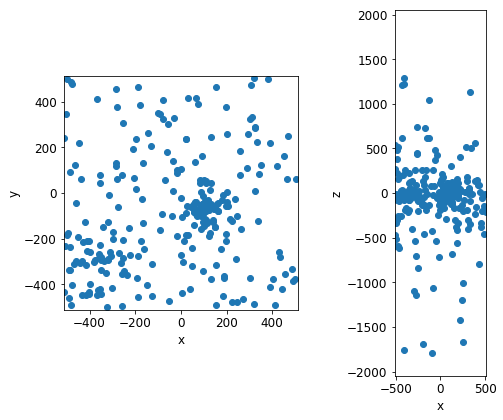

In [153]:
# Let's plot star particles
plt.figure(figsize=(8,6))
#First, project positions onto the horizontal plane (x,y):
hor=plt.subplot(121,aspect='equal')
hor=plt.plot(sp['x1'],sp['x2'],'o')
plt.axis(xyextent)
plt.xlabel('x')
plt.ylabel('y')
#Second, project positions onto the radial-vertical plane (x,z):
ver=plt.subplot(122,aspect='equal')
ver=plt.plot(sp['x1'],sp['x3'],'o')
plt.axis(xzextent)
plt.xlabel('x')
plt.ylabel('z')
plt.tight_layout()

In [154]:
# We would like to distinguish between active (young) star particles and inactive star 
# particles, and between cluster and runaway star particles 
# For age, we need the code unit of time in Myr
tunit_Myr=unit['time'].to('Myr').value
print tunit_Myr
#this is the same as:
print codetime.value

# First select young star particles (age < 40Myr)
# "young" is a boolean array: True for young, False for old
young=sp['age'] * tunit_Myr < 40.

print len(sp['age']),len(young)

#This is the number of young star particles:
print young.sum()

# Second, separate clusters (mass != 0) and runaways (mass == 0)
# (mass of runaway OB stars was set to zero in the code)
# "runaway" and "cluster" are also boolean arrays
runaway=sp['mass'] == 0
cluster=sp['mass'] != 0

print runaway.sum(),cluster.sum(),runaway.sum()+cluster.sum()
# young * cluster is True for young and cluster particles
young_cluster = young & cluster
young_runaway = young & runaway

print young_cluster.sum()
# Note that all runaways are young
print young_runaway.sum(),runaway.sum()

0.977792221673
0.977792221673
270 270
250
248 22 270
2
248 248


In [155]:
#You can also define an array of just the young sp
young_sp=sp[sp['age']*tunit_Myr < 40.]
#young_sp[0:10]
#And arrays of young cluster and runaways
young_cluster_sp=young_sp[young_sp['mass'] != 0]
runaway_sp=young_sp[young_sp['mass'] == 0]
print len(runaway_sp)
young_cluster_sp

248


,age,id,mass,time,v1,v2,v3,x1,x2,x3
67,7.059039,6761,2183165.5,400.0025,-2.347809,-2.022691,4.005070,93.845802,-64.794884,10.239429
120,33.173809,6122,5491172.0,400.0025,6.268635,10.339110,-0.827643,-319.257843,-293.345062,0.752446


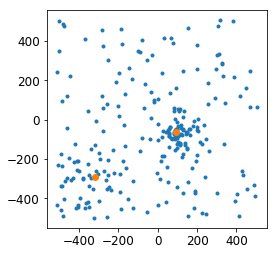

In [156]:
#Now let's plot the young clusters and runaways with different symbols
plt.subplot(111,aspect='equal')
plt.plot(runaway_sp['x1'],runaway_sp['x2'],'.')
plt.plot(young_cluster_sp['x1'],young_cluster_sp['x2'],'o')

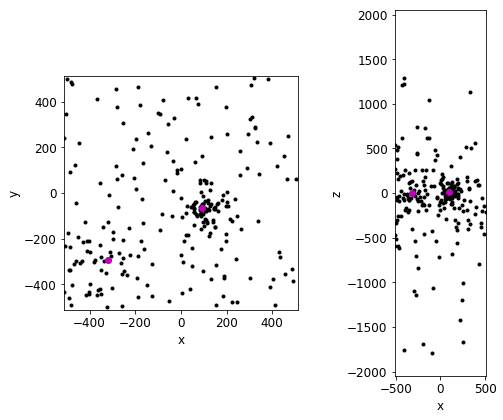

In [157]:
#You can also use the Boolean arrays to select the points you want to plot
# Here we also explictly set the box size, and choose colors for symbols
plt.figure(figsize=(8,6))
plt.subplot(121,aspect='equal')
plt.plot(sp['x1'][runaway],sp['x2'][runaway],'k.')
plt.plot(sp['x1'][young_cluster],sp['x2'][young_cluster],'mo')
plt.axis(xyextent)
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(122,aspect='equal')
plt.plot(sp['x1'][runaway],sp['x3'][runaway],'k.')
plt.plot(sp['x1'][young_cluster],sp['x3'][young_cluster],'mo')
plt.axis(xzextent)
plt.xlabel('x')
plt.ylabel('z')
plt.tight_layout()


<function matplotlib.pyplot.imshow>

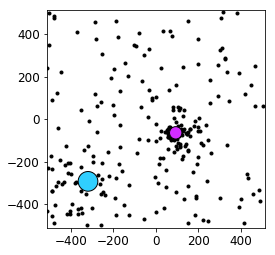

In [158]:
#We can also choose the size and color of points to represent attributes of the star particles, e.g. mass and age
#This converts the mass to Msun and age to Myr:
mass=young_cluster_sp['mass']*codemass.value
age=young_cluster_sp['age']*codetime.value
ax=plt.subplot(111,aspect='equal')
plt.axis(xyextent)
plt.plot(runaway_sp['x1'],runaway_sp['x2'],'.k',zorder=0)
ax.scatter(young_cluster_sp['x1'],young_cluster_sp['x2'],marker='o',s=mass/500.,c=age,edgecolor='black', linewidth='1',
           vmax=40,vmin=0,cmap=plt.cm.cool_r,zorder=1 )
plt.imshow

In [159]:
#You can modularize your code by defining functions
# For example, let's define some functions used in plotting star particles
def mass_norm(mass):
    '''
    Mass normlization function to determine symbol size
    This should be called both in sp_plot and sp_legend for the consistent result
    '''
    #return np.sqrt(mass)
    return mass/100.

def sp_plot(ax,sp):
    '''
    This function plots star particles 
    '''
    import pyathena as pa
    unit=pa.set_units(muH=1.4271)
    tunit_Myr=unit['time'].to('Myr').value
    munit_Msun=unit['mass'].to('Msun').value
     
    young_sp=sp[sp['age']*tunit_Myr < 40.]
    runaway=young_sp[young_sp['mass'] == 0]
    young_cluster=young_sp[young_sp['mass'] != 0]
    
    mass=young_cluster['mass']*munit_Msun
    age=young_cluster['age']*tunit_Myr
    
    
    cl=ax.scatter(young_cluster['x1'],young_cluster['x2'],marker='o',s=mass_norm(mass),c=age,edgecolor='black', linewidth='1',
               vmax=40,vmin=0,cmap=plt.cm.cool_r,zorder=2)
    ax.scatter(runaway['x1'],runaway['x2'],marker='.',color='k',zorder=1)
    
    
    return cl

def sp_legend(ax,ref_mass=[1.e3,1.e4,1.e5]):
    ext=ax.images[0].get_extent()

    #plot particle references outside of the domain of interest
    s=[]
    label=[]
    for mass in ref_mass:
        s.append(ax.scatter(ext[1]*2,ext[3]*2,s=mass_norm(mass),color='k',alpha=.5))
        label.append(r'$10^%d M_\odot$' % np.log10(mass))
    ax.set_xlim(ext[0],ext[1])
    ax.set_ylim(ext[2],ext[3])
    legend=ax.legend(s,label,scatterpoints=1,loc=2,ncol=3,fontsize='small',bbox_to_anchor=(0.0, 1.1), frameon=False)
    
    return legend



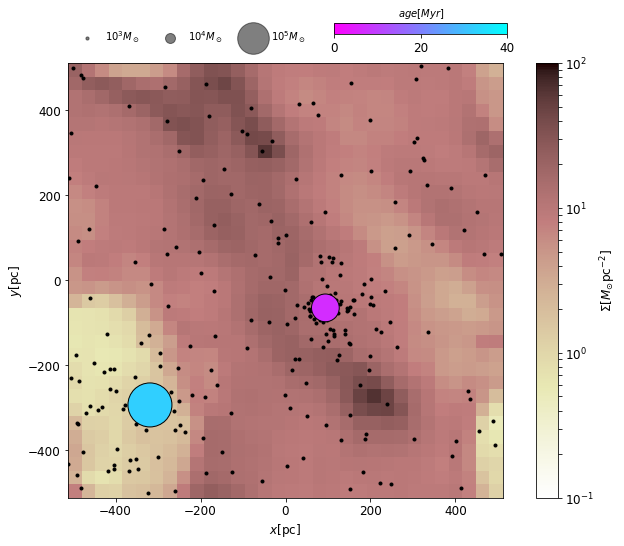

In [160]:
# let's combine surface density map with star particles.

fig=plt.figure(figsize=(12,8))

plt.rcParams['font.size']=12

plt.axis(xyextent)
ax=fig.add_subplot(111)

im=ax.imshow(surf,norm=LogNorm(),origin='lower',zorder=0,extent=xyextent,cmap='pink_r',clim=[1.e-1,1.e2])
cbar=plt.colorbar(im)
cbar.set_label(r'$\Sigma [M_{\odot} {\rm pc}^{-2}]$')
ax.set_xlabel(r'$x [{\rm pc}]$')
ax.set_ylabel(r'$y [{\rm pc}]$')

#This uses the star particle plotting and legend
cl=sp_plot(ax,sp)
leg=sp_legend(ax)

# Now adding the colorbar for cluster particles
cax1 = fig.add_axes([0.55, 0.93, 0.2, 0.02])
cbar=plt.colorbar(cl,ticks=[0,20,40],cax=cax1,orientation='horizontal')
cbar.ax.set_title(r'$age [Myr]$',size='small')

# You can save the figure by uncommenting the following command
#fig.savefig(os.path.join(outpath,'surfmap.png'),bbox_inches='tight')

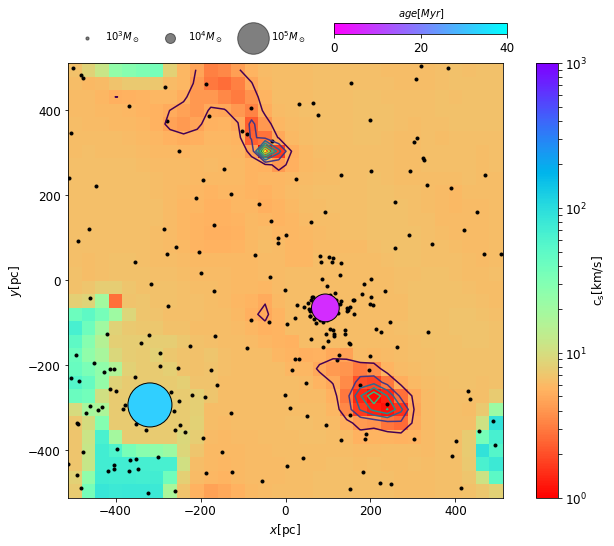

In [161]:
#Let's plot a slice of sound speed in color scale and density with contours
# First calculate sound speed
P=ds.read_all_data('pressure')
cs=np.sqrt(P/d)

fig=plt.figure(figsize=(12,8))

plt.rcParams['font.size']=12

plt.axis(xyextent)
ax=fig.add_subplot(111)

im=ax.imshow(cs[imax[2],:,:],norm=LogNorm(vmin=1,vmax=1.e3),origin='lower',zorder=0,extent=xyextent,cmap='rainbow_r')
cbar=plt.colorbar(im)
cbar.set_label(r'$\rm c_s [km/s]$')
ax.set_xlabel(r'$x [{\rm pc}]$')
ax.set_ylabel(r'$y [{\rm pc}]$')

X, Y = np.meshgrid(x,y)
ct=plt.contour(X,Y,d[imax[2],:,:])

#you can reuse the star particle plotting functions
sp_plot(ax,sp)
sp_legend(ax)

# Now adding the colorbar for cluster particles
cax1 = fig.add_axes([0.55, 0.93, 0.2, 0.02])
cbar=plt.colorbar(cl,ticks=[0,20,40],cax=cax1,orientation='horizontal')
cbar.ax.set_title(r'$age [Myr]$',size='small')

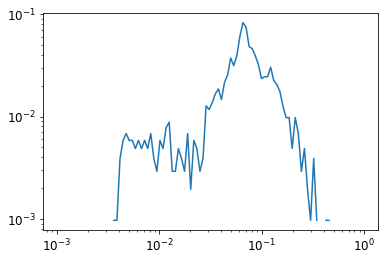

In [162]:
#You can analyze the data
# For example, here's a histogram of the mean density projected on the xy-plane
xyproj=dproj[0]
h,edges=np.histogram(np.log10(xyproj),range=[-3,0],bins=100)
bins=0.5*(edges[1:]+edges[:-1])
plt.loglog(10.**bins,h/float(h.sum()))

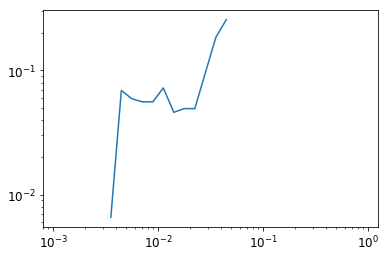

In [163]:
# You can select just part of the data to analyze
idx=xyproj >0.05
h,edges=np.histogram(np.log10(xyproj[~idx]),range=[-3,0],bins=30)
bins=0.5*(edges[1:]+edges[:-1])
plt.loglog(10.**bins,h/float(h.sum()))

In [164]:
#This zeroes out all of the high-density values, and plots an image of the low-density region
tmp=np.zeros(xyproj.shape)
tmp[~idx]=xyproj[~idx]

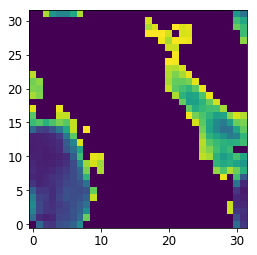

In [165]:
plt.imshow(tmp,origin='lower')

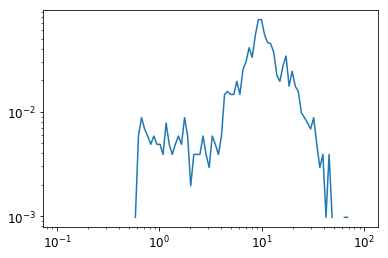

In [166]:
# histogram of surface density
h,edges=np.histogram(np.log10(surf),range=[-1,2],bins=100)
bins=0.5*(edges[1:]+edges[:-1])
plt.loglog(10.**bins,h/float(h.sum()))

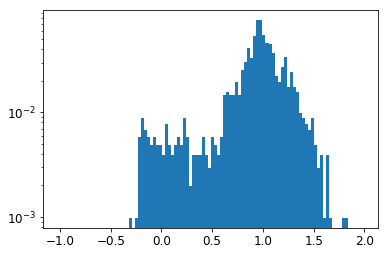

In [167]:
# bar plot
wbin=np.diff(edges)
plt.bar(edges[0:-1],h/float(h.sum()),width=wbin)
plt.yscale('log')